# 「実データで学ぶ人工知能講座」知能情報学
### *2020 ライフデザイン・イノベーション研究拠点 データビリティ人材育成「実データで学ぶ人工知能講座」教材*

---
## 『異常検知その1 & その2』
### 原 聡（大阪大学 産業科学研究所）

---
### 準備: CVXOPTのインストール

In [1]:
%%capture
!pip install cvxopt

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import chi2
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
import cvxopt

---
## 0. 外れ値の影響
### p.4

In [3]:
# 身長と体重
x = np.array([172, 179, 161, 165, 170])
x2 = np.array([172, 179, 161, 165, 17])
y = np.array([68, 71, 58, 60, 70])

# 平均
print(np.mean(x), np.mean(y))
print(np.mean(x2), np.mean(y))

169.4 65.4
138.8 65.4


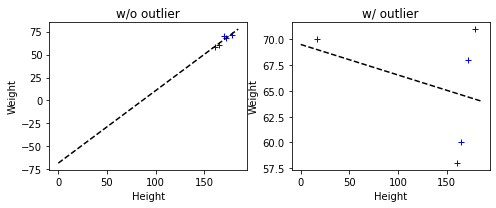

In [4]:
# 回帰直線
X = np.c_[x, np.ones(x.size)]
X2 = np.c_[x2, np.ones(x2.size)]
a, _, _, _ = np.linalg.lstsq(X, y, rcond=-1)
a2, _, _, _ = np.linalg.lstsq(X2, y, rcond=-1)

# データと回帰直線の描画
t = np.linspace(0, 185, 11)
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'b+')
plt.plot(t, a[0]*t+a[1], 'k--')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('w/o outlier')
plt.subplot(1, 2, 2)
plt.plot(x2, y, 'b+')
plt.plot(t, a2[0]*t+a2[1], 'k--')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('w/ outlier')
plt.tight_layout()
plt.show()

---
# その1

---
## 1. 密度推定と外れ値検知（正規分布の場合）

### p.19: 一変数の正規分布の描画

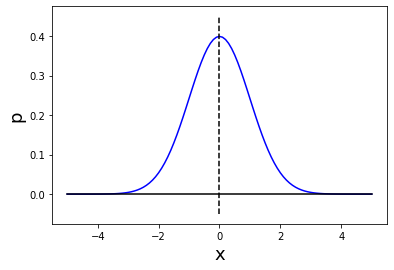

In [5]:
# x
t = np.linspace(-5, 5, 101)

# 正規分布の密度関数
p = np.exp(-t**2/2) / np.sqrt(2 * np.pi)

# 横軸にx、縦軸にpを描画
plt.plot(t, p, 'b-')
plt.plot([t[0], t[-1]], [0, 0], 'k-')
plt.plot([0, 0], [-0.05, 0.45], 'k--')
plt.xlabel('x', fontsize=18)
plt.ylabel('p', fontsize=18)
plt.show()

### p.22: 一変数の正規分布の推定

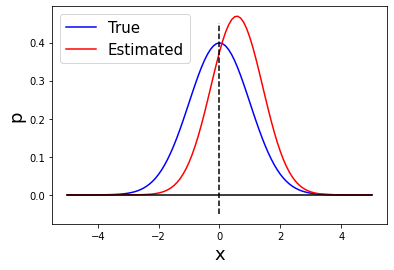

In [6]:
# 乱数の初期化
np.random.seed(0)

# データ数
n = 20

# 正規乱数の生成
x = np.random.randn(n)

# 平均の推定
#m = np.mean(x)
m = np.sum(x) / x.size

# 標準偏差の推定
#s = np.std(x)
s = np.sqrt(np.sum((x - m)**2) / x.size)

# 正規分布の密度関数
t = np.linspace(-5, 5, 101)
p = np.exp(-t**2/2) / np.sqrt(2 * np.pi) # 真の密度関数
q = np.exp(-(t-m)**2/(2 * s**2)) / np.sqrt(2 * np.pi * s**2) # 推定された密度関数

# 横軸にx、縦軸にp, qを描画
plt.plot(t, p, 'b-')
plt.plot(t, q, 'r-')
plt.plot([t[0], t[-1]], [0, 0], 'k-')
plt.plot([0, 0], [-0.05, 0.45], 'k--')
plt.xlabel('x', fontsize=18)
plt.ylabel('p', fontsize=18)
plt.legend(['True', 'Estimated'], fontsize=15)
plt.show()

### p.26: 一変数の正規分布の推定と外れ値検知

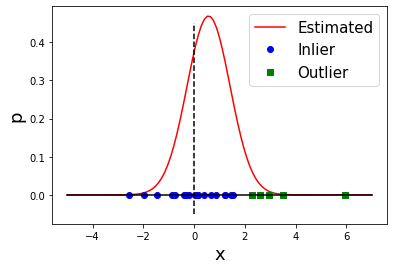

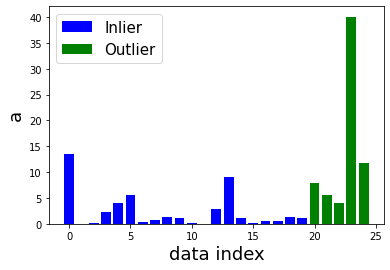

In [7]:
# 乱数の初期化
np.random.seed(0)

# データ数
n = 20 # 正常データ数
ny = 5 # 異常データ数

# 正規乱数の生成
x = np.random.randn(n) # 分布推定用データ

# 平均の推定
#m = np.mean(x)
m = np.sum(x) / x.size

# 標準偏差の推定
#s = np.std(x)
s = np.sqrt(np.sum((x - m)**2) / x.size)

# テスト用データ - 外れ値は平均が4.0の正規分布から生成
y1 = np.random.randn(n) # テスト用正常データ
y2 = np.random.randn(ny) + 4.0 # テスト用異常データ
y = np.r_[y1, y2]

# 密度関数と外れ値の描画
t = np.linspace(-5, 7, 101)
q = np.exp(-(t-m)**2/(2 * s**2)) / np.sqrt(2 * np.pi * s**2)
plt.plot(t, q, 'r-')
plt.plot(y[:n], [0]*n, 'bo')
plt.plot(y[n:], [0]*ny, 'gs')
plt.plot([t[0], t[-1]], [0, 0], 'k-')
plt.plot([0, 0], [-0.05, 0.45], 'k--')
plt.xlabel('x', fontsize=18)
plt.ylabel('p', fontsize=18)
plt.legend(['Estimated', 'Inlier', 'Outlier'], fontsize=15)
plt.show()

# 異常度 = -log p
ax = (x - m)**2 / s**2
ay = (y - m)**2 / s**2

# 横軸にデータ、縦軸に異常度を描画
plt.bar(range(n), ay[:n], color='b')
plt.bar(range(n, n+ny), ay[n:], color='g')
plt.xlabel('data index', fontsize=18)
plt.ylabel('a', fontsize=18)
plt.legend(['Inlier', 'Outlier'], fontsize=15)
plt.show()

### p.28: Hotteling's T2の実験評価

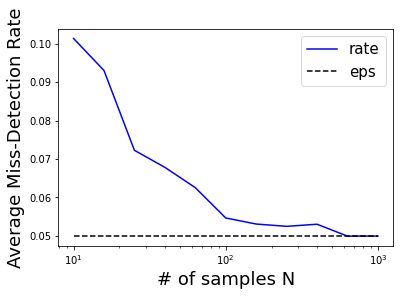

In [8]:
# 間違え確率と閾値
eps = 0.05
delta = chi2.ppf(1-eps, 1)

# 学習データの個数を変えながら実際に間違えた割合を計算
n_train = np.logspace(1, 3, 11)
c = []
for i, n in enumerate(n_train):
    n = int(n)
    ci = []
    # 100回データを生成して評価
    for seed in range(100):
        # データ生成
        np.random.seed(seed+n)
        x_train = np.random.randn(n)
        x_test = np.random.randn(1000) # テストデータは1000個で固定

        # 平均、標準偏差の推定
        m = np.mean(x_train)
        s = np.std(x_train)

        # 指標の計算
        a = (x_test - m)**2 / s**2

        # 誤りの個数をカウント
        ci.append(np.mean(a >= delta))
    c.append([np.mean(ci), np.std(ci)])
c = np.array(c)

# 結果を描画
plt.figure()
ax = plt.subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(n_train, c[:, 0], 'b-')
plt.plot(n_train, [0.05]*n_train.size, 'k--')
plt.xlabel('# of samples N', fontsize=18)
plt.ylabel('Average Miss-Detection Rate', fontsize=18)
plt.legend(['rate', 'eps'], fontsize=15)
plt.show()

---
## 2. 異常検知精度の評価方法

### 準備：一変数の正規分布の推定と外れ値検知

In [9]:
# 乱数の初期化
np.random.seed(0)

# データ数
n = 20 # 正常データ数
ny = 5 # 異常データ数

# 正規乱数の生成
x = np.random.randn(n) # 分布推定用データ

# 平均の推定
#m = np.mean(x)
m = np.sum(x) / x.size

# 標準偏差の推定
#s = np.std(x)
s = np.sqrt(np.sum((x - m)**2) / x.size)

# テスト用データ - 外れ値は平均が4.0の正規分布から生成
y1 = np.random.randn(n) # テスト用正常データ
y2 = np.random.randn(ny) + 4.0 # テスト用異常データ
y = np.r_[y1, y2]

# 異常度 = -log p
ax = (x - m)**2 / s**2
ay = (y - m)**2 / s**2

### p.36: 真陽性率と偽陽性率

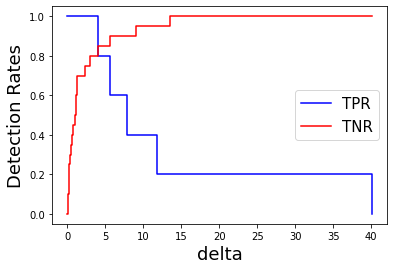

In [10]:
# 閾値δを変えながら真陽性率と偽陽性率を計算
delta = np.sort(ay)[:-1] + np.diff(np.sort(ay))
delta = np.r_[np.min(ay)-1e-8, delta]
flag = np.r_[np.zeros(n), np.ones(ny)]
rates = []
for d in delta:
    tpr = np.sum((ay > d) * flag) / np.sum(flag)
    fpr = np.sum((ay > d) * (1.0 - flag)) / np.sum(1.0 - flag)
    rates.append((tpr, fpr))
rates = np.array(rates)

# 各閾値δに対する真陽性率と偽陽性率をプロット
tpr = rates[:, 0]
fpr = rates[:, 1]
diff_of_rates = tpr - fpr
i = np.argmax(tpr - fpr)
plt.step(delta, tpr, 'b-', where='post') # tpr
plt.step(delta, 1-fpr, 'r-', where='post') # tnr
plt.xlabel('delta', fontsize=18)
plt.ylabel('Detection Rates', fontsize=18)
plt.legend(['TPR', 'TNR'], fontsize=15)
plt.show()

### p.37: ROC曲線とAUROC

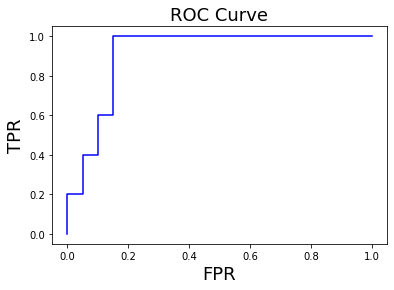

AUROC = 0.91
AUROC = 0.91


In [11]:
# ROC曲線の描画
plt.plot(fpr, tpr, 'b-')
plt.xlabel('FPR', fontsize=18)
plt.ylabel('TPR', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.show()

# AUROCの計算
f0 = 0.0
auc = 0.0
for f, t in zip(fpr[::-1], tpr[::-1]):
    auc += (f - f0) * t
    f0 = f
print('AUROC = %.2f' % (auc,))

# sklearnのroc_auc_scoreでも計算可能
auc = roc_auc_score(flag, ay)
print('AUROC = %.2f' % (auc,))

---
## 3. 発展的な密度推定法
---
## 多変量正規分布
### p.40: 二変数の正規分布の描画

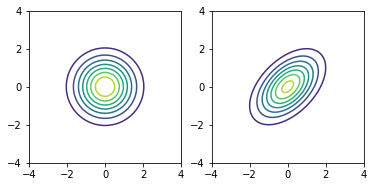

In [12]:
# x1, x2
x1 = np.linspace(-4, 4, 101)
x2 = np.linspace(-4, 4, 101)
X1, X2 = np.meshgrid(x1, x2)

# 共分散行列とその逆行列、行列式
S1 = np.identity(2)
S2 = np.array([[1, 0.5], [0.5, 1]])
C1 = np.linalg.inv(S1)
C2 = np.linalg.inv(S2)
s1 = np.linalg.det(S1)
s2 = np.linalg.det(S2)

# 正規分布の密度関数
p1 = np.exp(-(X1**2 * C1[0, 0] + 2 * C1[0, 1] * X1 * x2 + C1[1, 1] * X2**2)/2) / (2 * np.pi * np.sqrt(s1))
p2 = np.exp(-(X1**2 * C2[0, 0] + 2 * C2[0, 1] * X1 * X2 + C2[1, 1] * X2**2)/2) / (2 * np.pi * np.sqrt(s2))

# 横軸にx1、縦軸にx2、密度関数と等高線で描画
plt.subplot(1, 2, 1)
plt.contour(X1, X2, p1) 
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.contour(X1, X2, p2) 
plt.gca().set_aspect('equal')

plt.show()

### p.44: 二変数の正規分布の推定と外れ値検知

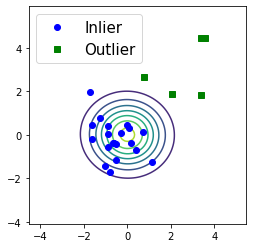

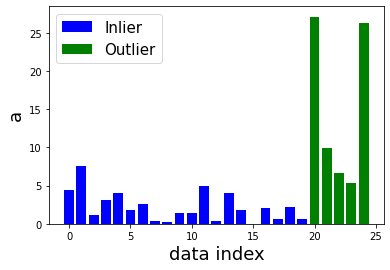

In [13]:
# 乱数の初期化
np.random.seed(0)

# 二変数の正規分布のパラメータ
# 正常データ分布： 平均と分散共分散行列
m1 = np.zeros(2)
S1 = np.identity(2)
# 異常データ分布： 平均と分散共分散行列
m2 = np.array([3, 3])
S2 = np.array([[1, 0.5], [0.5, 1]])

# データ数
n = 20 # 正常データ数
ny = 5 # 異常データ数

# 正規乱数の生成
x = np.random.multivariate_normal(m1, S1, n)

# 平均の推定
#m = np.mean(x, axis=0)
m = np.sum(x, axis=0) / x.shape[0]

# 標準偏差の推定
#V = np.cov(x.T, bias=True)
V = (x - m[np.newaxis, :]).T.dot(x - m[np.newaxis, :]) / x.shape[0]

# テスト用データ - 外れ値は平均が4.0の正規分布から生成
y1 = np.random.multivariate_normal(m1, S1, n) # テスト用正常データ
y2 = np.random.multivariate_normal(m2, S2, ny) # テスト用異常データ
y = np.r_[y1, y2]

# 異常度 = -log p
C = np.linalg.inv(V)
ay = np.sum(((y - m[np.newaxis, :]).dot(C) * (y - m[np.newaxis, :])), axis=1)

# 正規分布の密度関数
x1 = np.linspace(-4, 6, 101) - m[0]
x2 = np.linspace(-4, 6, 101) - m[1]
X1, X2 = np.meshgrid(x1, x2)
q = np.exp(-(X1**2 * C[0, 0] + 2 * C[0, 1] * X1 * X2 + C[1, 1] * X2**2)/2) / (2 * np.pi * np.sqrt(np.linalg.det(V)))
plt.plot(y[:n, 0], y[:n, 1], 'bo')
plt.plot(y[n:, 0], y[n:, 1], 'gs')
plt.contour(X1, X2, q) 
plt.gca().set_aspect('equal')
plt.legend(['Inlier', 'Outlier'], fontsize=15)
plt.show()

# 横軸にデータ、縦軸に異常度を描画
plt.bar(range(n), ay[:n], color='b')
plt.bar(range(n, n+ny), ay[n:], color='g')
plt.xlabel('data index', fontsize=18)
plt.ylabel('a', fontsize=18)
plt.legend(['Inlier', 'Outlier'], fontsize=15)
plt.show()

---
## カーネル密度推定と混合正規分布
### p.45 山が複数ある場合に正規分布によるモデル化は適切ではない

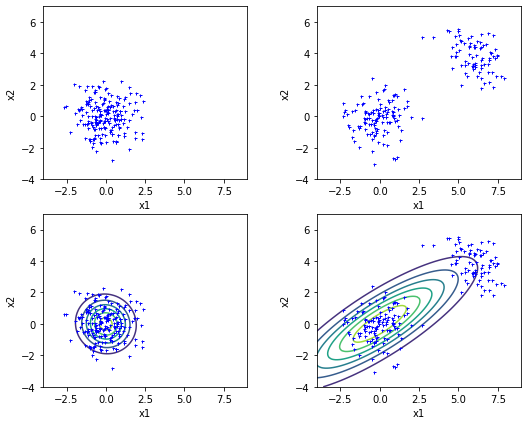

In [14]:
# データ：xは単峰、yは多峰
m1 = np.zeros(2)
m2 = np.array([6, 4])
S1 = np.identity(2)
S2 = np.array([[1, -0.5], [-0.5, 1]])
np.random.seed(0)
x = np.random.multivariate_normal(m1, S1, 200)
y = np.random.multivariate_normal(m1, S1, 120)
y = np.r_[y, np.random.multivariate_normal(m2, S2, 80)]

# 平均と分散共分散行列の推定
m1_est = np.mean(x, axis=0)
S1_est = np.cov(x.T)
m2_est = np.mean(y, axis=0)
S2_est = np.cov(y.T)

# 推定された正規分布の密度関数
z1 = np.linspace(-4, 9, 101)
z2 = np.linspace(-4, 7, 101)
Z1, Z2 = np.meshgrid(z1, z2)
C1_est = np.linalg.inv(S1_est)
C2_est = np.linalg.inv(S2_est)
s1 = np.linalg.det(S1_est)
s2 = np.linalg.det(S2_est)
p1_est = np.exp(-(Z1**2 * C1_est[0, 0] + 2 * C1_est[0, 1] * Z1 * Z2 + C1_est[1, 1] * Z2**2)/2) / (2 * np.pi * np.sqrt(s1))
p2_est = np.exp(-(Z1**2 * C2_est[0, 0] + 2 * C2_est[0, 1] * Z1 * Z2 + C2_est[1, 1] * Z2**2)/2) / (2 * np.pi * np.sqrt(s2))

# 描画
plt.figure(figsize=(9, 7))
plt.subplot(2, 2, 1)
plt.plot(x[:, 0], x[:, 1], 'b+', markersize=3)
plt.gca().set_aspect('equal')
plt.xlim([-4, 9])
plt.ylim([-4, 7])
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(2, 2, 2)
plt.plot(y[:, 0], y[:, 1], 'b+', markersize=3)
plt.gca().set_aspect('equal')
plt.xlim([-4, 9])
plt.ylim([-4, 7])
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(2, 2, 3)
plt.plot(x[:, 0], x[:, 1], 'b+', markersize=3)
plt.contour(Z1, Z2, p1_est) 
plt.gca().set_aspect('equal')
plt.xlim([-4, 9])
plt.ylim([-4, 7])
plt.xlabel('x1')
plt.ylabel('x2')

plt.subplot(2, 2, 4)
plt.plot(y[:, 0], y[:, 1], 'b+', markersize=3)
plt.contour(Z1, Z2, p2_est) 
plt.gca().set_aspect('equal')
plt.xlim([-4, 9])
plt.ylim([-4, 7])
plt.xlabel('x1')
plt.ylabel('x2')

plt.show()

### p.46: カーネル密度推定と混合正規分布の例

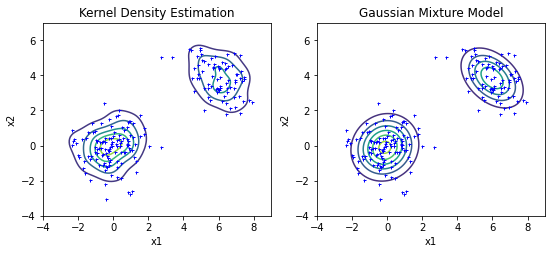

In [15]:
# カーネル密度推定
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(y)
q_kernel = kde.score_samples(np.c_[Z1.flatten(), Z2.flatten()])
q_kernel = q_kernel.reshape(Z1.shape)
q_kernel = np.exp(q_kernel)

# 混合正規分布推定
gmm = GaussianMixture(n_components=2)
gmm.fit(y)
q_gmm = gmm.score_samples(np.c_[Z1.flatten(), Z2.flatten()])
q_gmm = q_gmm.reshape(Z1.shape)
q_gmm = np.exp(q_gmm)

# 描画
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.plot(y[:, 0], y[:, 1], 'b+', markersize=3)
plt.contour(Z1, Z2, q_kernel) 
plt.gca().set_aspect('equal')
plt.xlim([-4, 9])
plt.ylim([-4, 7])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Kernel Density Estimation')

plt.subplot(1, 2, 2)
plt.plot(y[:, 0], y[:, 1], 'b+', markersize=3)
plt.contour(Z1, Z2, q_gmm) 
plt.gca().set_aspect('equal')
plt.xlim([-4, 9])
plt.ylim([-4, 7])
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Gaussian Mixture Model')

plt.show()

### p.50: ヒストグラムとカーネル密度推定

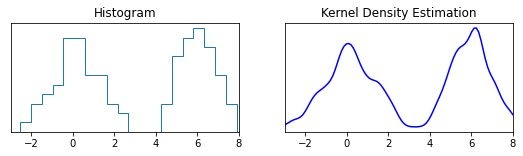

In [16]:
# データ
np.random.seed(0)
x = np.random.randn(50, 1)
x = np.r_[x, np.random.randn(50, 1) + 6]

# カーネル密度推定
kde = KernelDensity(kernel='gaussian', bandwidth=0.3).fit(x)
t = np.linspace(-3, 8, 101)[:, np.newaxis]
q_kernel = kde.score_samples(t)
q_kernel = np.exp(q_kernel)

# 描画
plt.figure(figsize=(9, 2))
plt.subplot(1, 2, 1)
plt.hist(x, bins=20, histtype='step')
plt.xlim([-3, 8])
plt.yticks([])
plt.title('Histogram')

plt.subplot(1, 2, 2)
plt.plot(t, q_kernel, 'b-')
plt.xlim([-3, 8])
plt.yticks([])
plt.title('Kernel Density Estimation')

plt.show()

### p.52: カーネル幅hと推定される関数の形状の関係

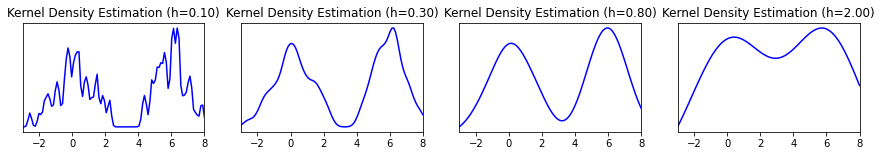

In [17]:
# データ
np.random.seed(0)
x = np.random.randn(50, 1)
x = np.r_[x, np.random.randn(50, 1) + 6]

# bandwidthを変えならがらカーネル密度推定
t = np.linspace(-3, 8, 101)[:, np.newaxis]
hs = [0.1, 0.3, 0.8, 2.0]
plt.figure(figsize=(15, 2))
for i, h in enumerate(hs):
    kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(x)
    q_kernel = kde.score_samples(t)
    q_kernel = np.exp(q_kernel)
    plt.subplot(1, len(hs), i+1)
    plt.plot(t, q_kernel, 'b-')
    plt.xlim([-3, 8])
    plt.yticks([])
    plt.title('Kernel Density Estimation (h=%.2f)' % (h,))
plt.show()

---
# その2

---
## 1. 近傍距離に基づく外れ値検知

### 準備：データの生成

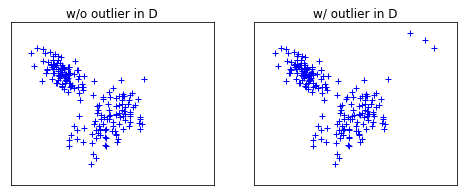

In [18]:
# 乱数の初期化
np.random.seed(0)

# データ
m1 = np.zeros(2)
S1 = np.array([[1, 0.5], [0.5, 1]])
m2 = np.array([-3, 3])
S2 = np.array([[0.5, -0.3], [-0.3, 0.5]])
x = np.random.multivariate_normal(m1, S1, 100)
x = np.r_[x, np.random.multivariate_normal(m2, S2, 100)] # 正常データ
x2 = np.r_[x, np.array([[4.11, 4.91], [4.61, 4.41], [3.21, 5.31]])] # 外れ値

# 正常データの描画
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.xlim([-6, 6])
plt.ylim([-4, 6])
plt.xticks([])
plt.yticks([])
plt.title('w/o outlier in D')

# 外れ値込みのデータの描画
plt.subplot(1, 2, 2)
plt.plot(x2[:, 0], x2[:, 1], 'b+')
plt.xlim([-6, 6])
plt.ylim([-4, 6])
plt.xticks([])
plt.yticks([])
plt.title('w/ outlier in D')
plt.show()

### p.61: 近傍距離に基づく外れ値検知

In [19]:
# k-近傍距離
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, x):
        self.nbrs = NearestNeighbors(n_neighbors=self.k, algorithm='ball_tree').fit(x)
        return self

    def anomaly_score(self, x):
        dist, _ = self.nbrs.kneighbors(x)
        return np.log(dist[:, self.k-1])

# 距離epsilon-以下の点の個数
class EpsNN:
    def __init__(self, eps=1.0):
        self.eps = eps

    def fit(self, x):
        self.nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(x)
        return self

    def anomaly_score(self, x):
        dist, _ = self.nbrs.radius_neighbors(z, self.eps)
        return - np.log(1+np.array([d.size for d in dist]))

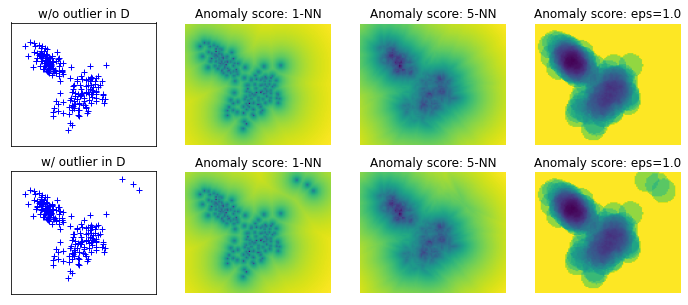

In [20]:
# 評価点
z1 = np.linspace(-6, 6, 101)
z2 = np.linspace(-4, 6, 101)
Z1, Z2 = np.meshgrid(z1, z2)
z = np.c_[Z1.flatten(), Z2.flatten()]

# 最近傍距離
nbrs1 = KNN(k=1).fit(x)
a11 = nbrs1.anomaly_score(z).reshape(Z1.shape)
nbrs1 = KNN(k=1).fit(x2)
a12 = nbrs1.anomaly_score(z).reshape(Z1.shape)

# k-近傍距離
k = 5
nbrsk = KNN(k=k).fit(x)
ak1 = nbrsk.anomaly_score(z).reshape(Z1.shape)
nbrsk = KNN(k=k).fit(x2)
ak2 = nbrsk.anomaly_score(z).reshape(Z1.shape)

# 距離epsilon-以下の点の個数
nbrse = EpsNN(eps=1.0).fit(x)
ae1 = nbrse.anomaly_score(z).reshape(Z1.shape)
nbrse = EpsNN(eps=1.0).fit(x2)
ae2 = nbrse.anomaly_score(z).reshape(Z1.shape)

# 外れ値度合いの描画
plt.figure(figsize=(12, 5))
plt.subplot(2, 4, 1)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.xlim([-6, 6])
plt.ylim([-4, 6])
plt.xticks([])
plt.yticks([])
plt.title('w/o outlier in D')
plt.subplot(2, 4, 5)
plt.plot(x2[:, 0], x2[:, 1], 'b+')
plt.xlim([-6, 6])
plt.ylim([-4, 6])
plt.xticks([])
plt.yticks([])
plt.title('w/ outlier in D')
plt.subplot(2, 4, 2)
plt.imshow(a11[::-1, :], extent=(-6, 6, -4, 6))
plt.axis('off')
plt.title('Anomaly score: 1-NN')
plt.subplot(2, 4, 6)
plt.imshow(a12[::-1, :], extent=(-6, 6, -4, 6))
plt.axis('off')
plt.title('Anomaly score: 1-NN')
plt.subplot(2, 4, 3)
plt.imshow(ak1[::-1, :], extent=(-6, 6, -4, 6))
plt.axis('off')
plt.title('Anomaly score: 5-NN')
plt.subplot(2, 4, 7)
plt.imshow(ak2[::-1, :], extent=(-6, 6, -4, 6))
plt.axis('off')
plt.title('Anomaly score: 5-NN')
plt.subplot(2, 4, 4)
plt.imshow(ae1[::-1, :], extent=(-6, 6, -4, 6))
plt.axis('off')
plt.title('Anomaly score: eps=1.0')
plt.subplot(2, 4, 8)
plt.imshow(ae2[::-1, :], extent=(-6, 6, -4, 6))
plt.axis('off')
plt.title('Anomaly score: eps=1.0')

plt.show()

### p.64: LOF

In [21]:
class LOF:
    def fit(self, x):
        self.x = x.copy()
        self.nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(x)
        return self

    def anomaly_score(self, x):
        n = x.shape[0]
        dist, ind = self.nbrs.kneighbors(x)
        a = []
        for i in range(n):
            dist_sub, _ = self.nbrs.kneighbors(self.x[ind[i, 0], :][np.newaxis, :])
            a.append(dist[i, 0] / dist_sub[0, 1])
        return np.array(a)

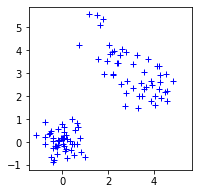

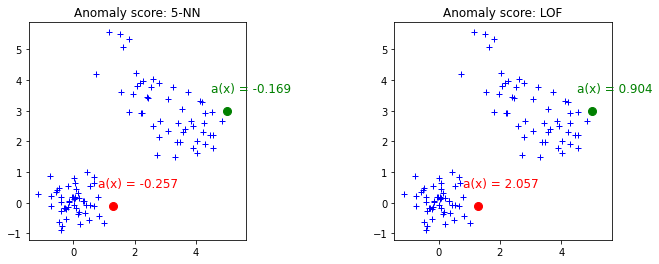

In [22]:
# 乱数の初期化
np.random.seed(0)

# データ
m1 = np.zeros(2)
S1 = 0.2 * np.identity(2)
m2 = np.array([3, 3])
S2 = np.array([[1, -0.7], [-0.7, 1]])
x = np.random.multivariate_normal(m1, S1, 50)
x = np.r_[x, np.random.multivariate_normal(m2, S2, 50)]
y1 = np.array([[1.3, -0.1]])
y2 = np.array([[5.0, 3.0]])

# データの描画
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.axis('square')
plt.show()

# k-近傍
k = 5
nbrsk = KNN(k=k).fit(x)
ak = nbrsk.anomaly_score(np.r_[y1, y2])

# LOF
lof = LOF().fit(x)
al = lof.anomaly_score(np.r_[y1, y2])

# 描画
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.plot(y1[:, 0], y1[:, 1], 'ro', markersize=8)
plt.text(y1[:, 0]-0.5, y1[:, 1]+0.5, 'a(x) = %.3f' % (ak[0],), va='bottom', ha='left', color='r', fontsize=12)
plt.plot(y2[:, 0], y2[:, 1], 'go', markersize=8)
plt.text(y2[:, 0]-0.5, y2[:, 1]+0.5, 'a(x) = %.3f' % (ak[1],), va='bottom', ha='left', color='g', fontsize=12)
plt.title('Anomaly score: 5-NN')
plt.axis('square')
plt.subplot(1, 2, 2)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.plot(y1[:, 0], y1[:, 1], 'ro', markersize=8)
plt.text(y1[:, 0]-0.5, y1[:, 1]+0.5, 'a(x) = %.3f' % (al[0],), va='bottom', ha='left', color='r', fontsize=12)
plt.plot(y2[:, 0], y2[:, 1], 'go', markersize=8)
plt.text(y2[:, 0]-0.5, y2[:, 1]+0.5, 'a(x) = %.3f' % (al[1],), va='bottom', ha='left', color='g', fontsize=12)
plt.title('Anomaly score: LOF')
plt.axis('square')
plt.show()

## 2. 領域分割に基づく外れ値検知

### 準備：凸二次計画問題のソルバーとSVDDクラス

In [23]:
def solveQP(P, q, C):
    m = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(np.ones((1,m)))
    b = cvxopt.matrix(np.array([1.0]))
    G = cvxopt.matrix(np.r_[-np.identity(m), np.identity(m)])
    h = cvxopt.matrix(np.r_[np.zeros(m), C*np.ones(m)])
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(P,q,A=A,b=b,G=G,h=h)
    ans = np.transpose(np.array(sol['x']))
    return ans[0]

class SVDD:
    def __init__(self, C=0.1, tol=1e-6):
        self.C = C
        self.tol = tol

    def fit(self, x):

        # 最適化問題を解く
        K = x.dot(x.T)
        P = 2 * K
        q = - np.diag(K)
        self.beta = solveQP(P, q, self.C)

        # 球の中心bと半径Rを求める
        idx_boundary = np.where((self.beta >= self.tol) * (self.beta <= self.C - self.tol))[0]
        self.b = x.T.dot(self.beta)
        self.R = np.linalg.norm(x[idx_boundary, :] - self.b, axis=1).max()
        return self

    def anomaly_score(self, x):
        # 球からの"はみ出し"を計算する
        return np.linalg.norm(x - self.b, axis=1) - self.R

### p.72: SVDDの例

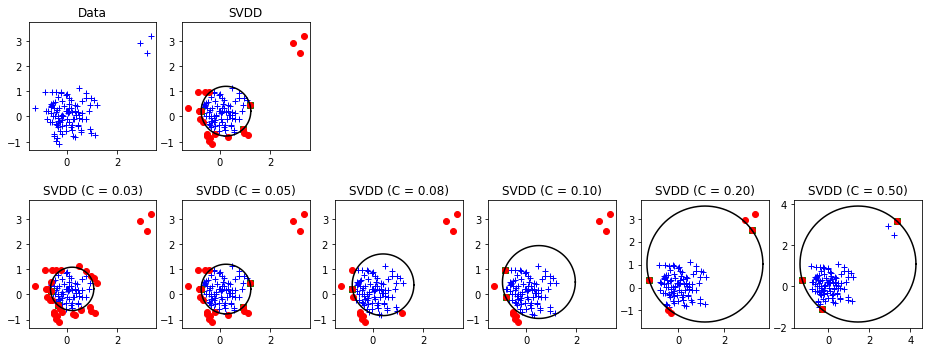

In [24]:
# データの生成
np.random.seed(0)
x = 0.5 * np.random.randn(100, 2)
x = np.r_[x, 0.3 * np.random.randn(3, 2) + 3]
K = x.dot(x.T)
n = x.shape[0]

# データ描画
Cs = [0.03, 0.05, 0.08, 0.1, 0.2, 0.5]
plt.figure(figsize=[16, 6])
plt.subplot(2, len(Cs), 1)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.title('Data')
plt.axis('square')

# Cを変えながらSVDD
tol = 1e-6
for c, C in enumerate(Cs):
    svdd = SVDD(C=C, tol=tol).fit(x)
    b, R = svdd.b, svdd.R
    
    # 境界線
    t = np.linspace(0, 2*np.pi, 101)
    z = R * np.c_[np.cos(t), np.sin(t)] + b

    # 描画
    idx_inlier = np.where(svdd.beta <= svdd.C - svdd.tol)[0]
    idx_outlier = np.where(svdd.beta >= svdd.tol)[0]
    idx_boundary = np.where((svdd.beta >= svdd.tol) * (svdd.beta <= svdd.C - svdd.tol))[0]
    plt.subplot(2, len(Cs), len(Cs)+c+1)
    plt.plot(x[idx_inlier, 0], x[idx_inlier, 1], 'b+')
    plt.plot(x[idx_boundary, 0], x[idx_boundary, 1], 'gs')
    plt.plot(x[idx_outlier, 0], x[idx_outlier, 1], 'ro')
    plt.plot(z[:, 0], z[:, 1], 'k-')
    plt.axis('square')
    plt.title('SVDD (C = %.2f)' % (C,))
    if c==1:
        plt.subplot(2, len(Cs), 2)
        plt.plot(x[idx_inlier, 0], x[idx_inlier, 1], 'b+')
        plt.plot(x[idx_boundary, 0], x[idx_boundary, 1], 'gs')
        plt.plot(x[idx_outlier, 0], x[idx_outlier, 1], 'ro')
        plt.plot(z[:, 0], z[:, 1], 'k-')
        plt.axis('square')
        plt.title('SVDD')
plt.show()

### p.76: Kernel-SVDDの例

In [25]:
class KernelSVDD:
    def __init__(self, s=1.0, C=0.1, tol=1e-8):
        self.s = s
        self.C = C
        self.tol = tol

    def fit(self, x):
        self.x = x.copy() # テスト時に使うので学習データを保持しておく

        # 最適化問題を解く
        K = np.sum(x**2, axis=1)[:, np.newaxis] - 2 * x.dot(x.T) + np.sum(x**2, axis=1)[np.newaxis, :]
        K = np.exp(-self.s * K)
        P = 2 * K
        q = - np.diag(K)
        self.beta = solveQP(P, q, self.C)

        # 球の中心bと半径Rを求める
        self.k = K.dot(self.beta).dot(self.beta)
        idx_boundary = np.where((self.beta >= self.tol) * (self.beta <= self.C - self.tol))[0]
        Ri = np.sqrt(1 - 2 * K[idx_boundary, :].dot(self.beta) + self.k)
        self.R = Ri.max()
        return self

    def anomaly_score(self, x):
        # 球からの"はみ出し"を計算する
        K = np.sum(x**2, axis=1)[:, np.newaxis] - 2 * x.dot(self.x.T) + np.sum(self.x**2, axis=1)[np.newaxis, :]
        K = np.exp(-self.s * K)
        a = np.sqrt(1 - 2 * K.dot(self.beta) + self.k)
        return a - self.R

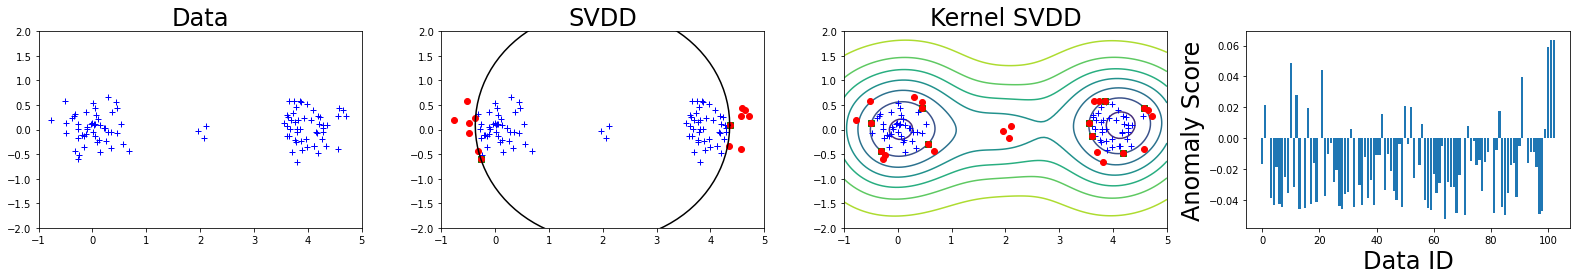

In [26]:
# データ
np.random.seed(0)
x = 0.3 * np.random.randn(50, 2)
x = np.r_[x, 0.3 * np.random.randn(50, 2) + np.array([4, 0])]
x = np.r_[x, 0.1 * np.random.randn(3, 2) + np.array([2, 0])]
n = x.shape[0]

# SVDD
svdd = SVDD(C=0.08, tol=1e-6).fit(x)
b, R = svdd.b, svdd.R

# 境界線 - SVDD
t = np.linspace(0, 2*np.pi, 101)
y = R * np.c_[np.cos(t), np.sin(t)] + b

# Kernel-SVDD
ksvdd = KernelSVDD(s=1.0, C=0.05, tol=1e-6).fit(x)
ak = ksvdd.anomaly_score(x)

# ヒートマップ - Kernel SVDD
z1 = np.linspace(-1, 5, 101)
z2 = np.linspace(-2, 2, 101)
Z1, Z2 = np.meshgrid(z1, z2)
z = np.c_[Z1.flatten(), Z2.flatten()]
a = ksvdd.anomaly_score(z)
a = a.reshape(Z1.shape)

# データ描画
plt.figure(figsize=[22, 4])
plt.subplot(1, 4, 1)
plt.plot(x[:, 0], x[:, 1], 'b+')
plt.xlim([-1, 5])
plt.ylim([-2, 2])
plt.title('Data', fontsize=24)

# SVDD結果描画
idx_inlier = np.where(svdd.beta <= svdd.C - svdd.tol)[0]
idx_outlier = np.where(svdd.beta >= svdd.tol)[0]
idx_boundary = np.where((svdd.beta >= svdd.tol) * (svdd.beta <= svdd.C - svdd.tol))[0]
plt.subplot(1, 4, 2)
plt.plot(x[idx_inlier, 0], x[idx_inlier, 1], 'b+')
plt.plot(x[idx_boundary, 0], x[idx_boundary, 1], 'gs')
plt.plot(x[idx_outlier, 0], x[idx_outlier, 1], 'ro')
plt.plot(y[:, 0], y[:, 1], 'k-')
plt.xlim([-1, 5])
plt.ylim([-2, 2])
plt.title('SVDD', fontsize=24)

plt.subplot(1, 4, 3)
idxk_inlier = np.where(ksvdd.beta <= ksvdd.C - ksvdd.tol)[0]
idxk_outlier = np.where(ksvdd.beta >= ksvdd.tol)[0]
idxk_boundary = np.where((ksvdd.beta >= ksvdd.tol) * (ksvdd.beta <= ksvdd.C - ksvdd.tol))[0]
plt.plot(x[idxk_inlier, 0], x[idxk_inlier, 1], 'b+')
plt.plot(x[idxk_boundary, 0], x[idxk_boundary, 1], 'gs')
plt.plot(x[idxk_outlier, 0], x[idxk_outlier, 1], 'ro')
plt.contour(Z1, Z2, a)
plt.xlim([-1, 5])
plt.ylim([-2, 2])
plt.title('Kernel SVDD', fontsize=24)

plt.subplot(1, 4, 4)
plt.bar(range(ak.size), ak)
plt.xlabel('Data ID', fontsize=24)
plt.ylabel('Anomaly Score', fontsize=24)

plt.tight_layout()
plt.show()

### p.74: データ変換前後の“球”

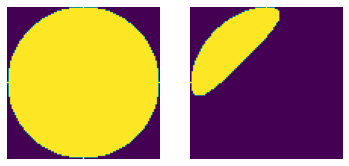

In [27]:
# グリッド
z1 = np.linspace(1, 3, 101)
z2 = np.linspace(1, 3, 101)
Z1, Z2 = np.meshgrid(z1, z2)
z = np.c_[Z1.flatten(), Z2.flatten()]
zz = np.c_[z[:, 0]*z[:, 1], z[:, 0], z[:, 1]]

# 球
v = (np.sum((z-2)**2, axis=1) <= 1).reshape(Z1.shape)
vv = (np.sum((zz-2)**2, axis=1) <= 1).reshape(Z1.shape)

# 描画
plt.figure(figsize=[6, 3])
plt.subplot(1, 2, 1)
plt.imshow(v)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(vv)
plt.axis('off')
plt.show()

## 3. ランダム分割に基づく外れ値検知

### p.78: ランダム分割の例

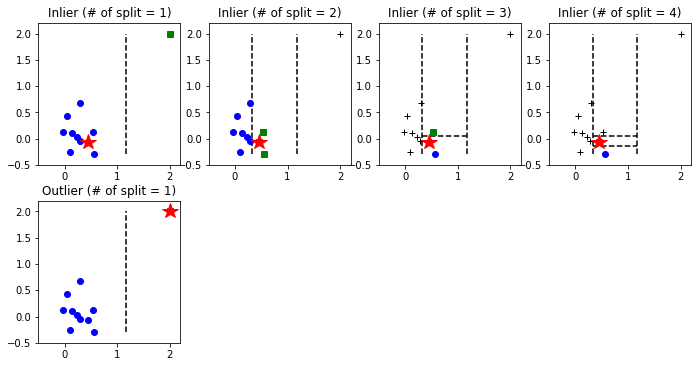

In [28]:
# データ
np.random.seed(0)
x = 0.3 * np.random.randn(10, 2)
x = np.r_[x, np.array([[2, 2]])]
d = 2
n = x.shape[0]

# 描画
plt.figure(figsize=[30, 6])
max_itr = 10
for c, target in enumerate([8, 10]):
    np.random.seed(0)
    idx = np.arange(n)
    rng = np.c_[np.min(x, axis=0), np.max(x, axis=0)]
    split = []
    for itr in range(max_itr):
        i = np.random.randint(d)
        t = (rng[i, 1] - rng[i, 0]) * np.random.rand() + rng[i, 0]
        id1 = np.where(x[:, i] >= t)[0]
        id2 = np.where(x[:, i] < t)[0]
        if target in id1:
            split.append((i, t, 0))
        else:
            split.append((i, t, 1))
        plt.subplot(2, max_itr, itr+1+c*max_itr)
        box = np.c_[np.min(x, axis=0), np.max(x, axis=0)]
        for s in split:
            if s[0] == 0:
                plt.plot([s[1], s[1]], [box[1, 0], box[1, 1]], 'k--')
            else:
                plt.plot([box[0, 0], box[0, 1]], [s[1], s[1]], 'k--')
            box[s[0], s[2]] = s[1]
        plt.plot(x[:, 0], x[:, 1], 'k+')
        plt.plot(x[np.intersect1d(id1, idx), 0], x[np.intersect1d(id1, idx), 1], 'gs')
        plt.plot(x[np.intersect1d(id2, idx), 0], x[np.intersect1d(id2, idx), 1], 'bo')
        plt.plot(x[target, 0], x[target, 1], 'r*', markersize=16)
        plt.axis('square')
        plt.xlim([-0.5, 2.2])
        plt.ylim([-0.5, 2.2])
        if c == 0:
            plt.title('Inlier (# of split = %d)' % (itr+1,))
        else:
            plt.title('Outlier (# of split = %d)' % (itr+1,))
        if target in id1:
            idx = np.intersect1d(id1, idx)
            rng = np.c_[np.min(x[idx, :], axis=0), np.max(x[idx, :], axis=0)]
        else:
            idx = np.intersect1d(id2, idx)
            rng = np.c_[np.min(x[idx, :], axis=0), np.max(x[idx, :], axis=0)]
        if idx.size == 1:
            break
plt.show()

### p.81: Isolation Forestの例

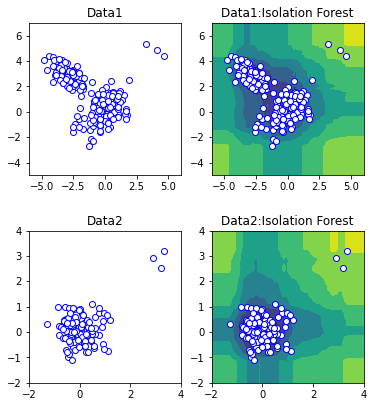

In [29]:
# データ1
np.random.seed(0)
m1 = np.zeros(2)
S1 = np.array([[1, 0.5], [0.5, 1]])
m2 = np.array([-3, 3])
S2 = np.array([[0.5, -0.3], [-0.3, 0.5]])
x = np.random.multivariate_normal(m1, S1, 100)
x = np.r_[x, np.random.multivariate_normal(m2, S2, 100)] # 正常データ
x = np.r_[x, np.array([[4.11, 4.91], [4.61, 4.41], [3.21, 5.31]])] # 外れ値

# データ2
np.random.seed(0)
y = 0.5 * np.random.randn(100, 2)
y = np.r_[y, 0.3 * np.random.randn(3, 2) + 3]

# Isolation Forest
forest = IsolationForest(contamination='auto')
forest.fit(x)
forest2 = IsolationForest(contamination='auto')
forest2.fit(y)

# 評価点
z1 = np.linspace(-6, 6, 101)
z2 = np.linspace(-5, 7, 101)
Z1, Z2 = np.meshgrid(z1, z2)
z = np.c_[Z1.flatten(), Z2.flatten()]
a = forest.decision_function(z).reshape(Z1.shape)
a = 2**(-a)
a2 = forest2.decision_function(z).reshape(Z1.shape)
a2 = 2**(-a2)

# 描画 - データ1
plt.figure(figsize=(6, 7))
plt.subplot(2, 2, 1)
plt.plot(x[:, 0], x[:, 1], 'wo', markeredgecolor='b')
plt.axis('square')
plt.xlim([-6, 6])
plt.ylim([-5, 7])
plt.title('Data1')
plt.subplot(2, 2, 2)
plt.plot(x[:, 0], x[:, 1], 'wo', markeredgecolor='b')
plt.contourf(Z1, Z2, a)
plt.axis('square')
plt.xlim([-6, 6])
plt.ylim([-5, 7])
plt.title('Data1:Isolation Forest')

# 描画 - データ2
plt.subplot(2, 2, 3)
plt.plot(y[:, 0], y[:, 1], 'wo', markeredgecolor='b')
plt.axis('square')
plt.xlim([-2, 4])
plt.ylim([-2, 4])
plt.title('Data2')
plt.subplot(2, 2, 4)
plt.plot(y[:, 0], y[:, 1], 'wo', markeredgecolor='b')
plt.contourf(Z1, Z2, a2)
plt.axis('square')
plt.xlim([-2, 4])
plt.ylim([-2, 4])
plt.title('Data2:Isolation Forest')

plt.show()